<a href="https://colab.research.google.com/github/GiovaniAngeloGitHub/Estudos/blob/main/TrackUSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total fragments pooled: 2499
Selected 375 USFs (threshold = 2.24350e-02)
Running t-SNE (this may take ~10-60s depending on data size)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


DBSCAN clusters found: 15 (including noise label -1)


/tmp/ipython-input-1975060995.py:201: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


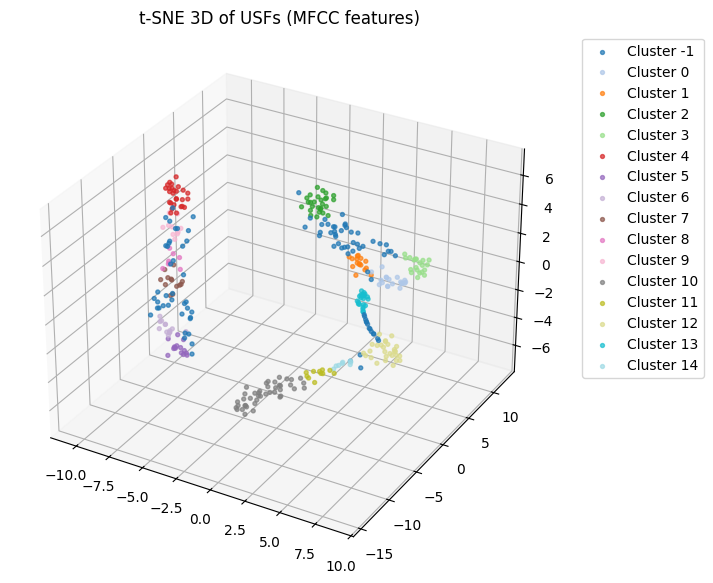

/tmp/ipython-input-1975060995.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


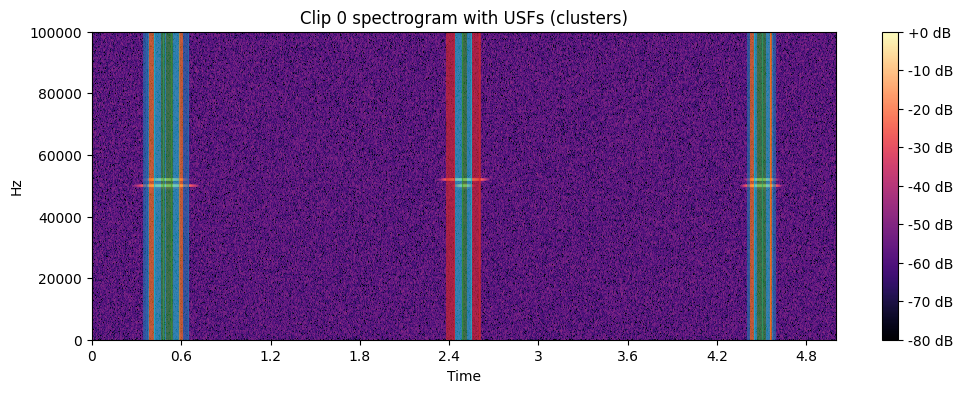

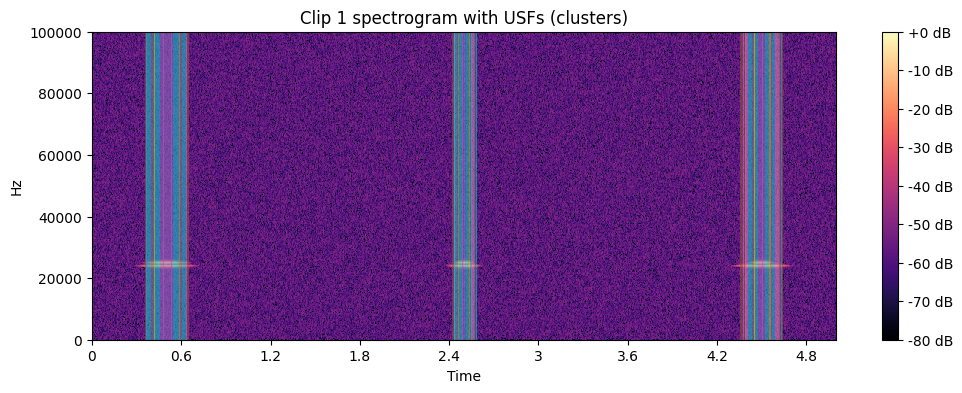

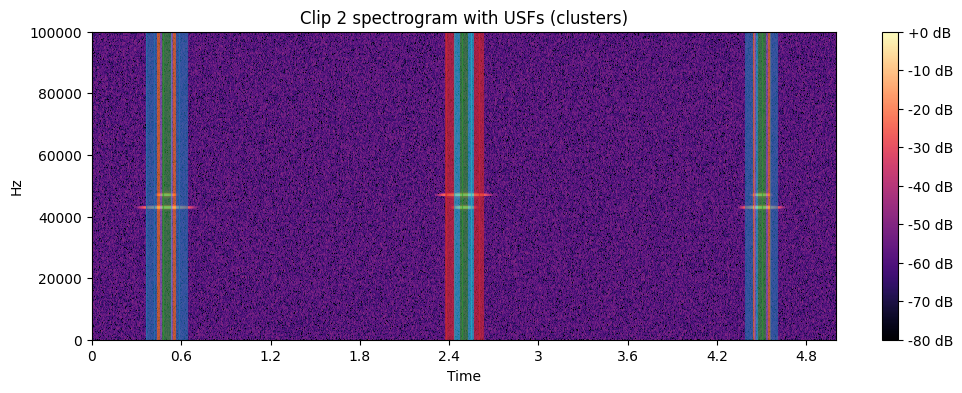

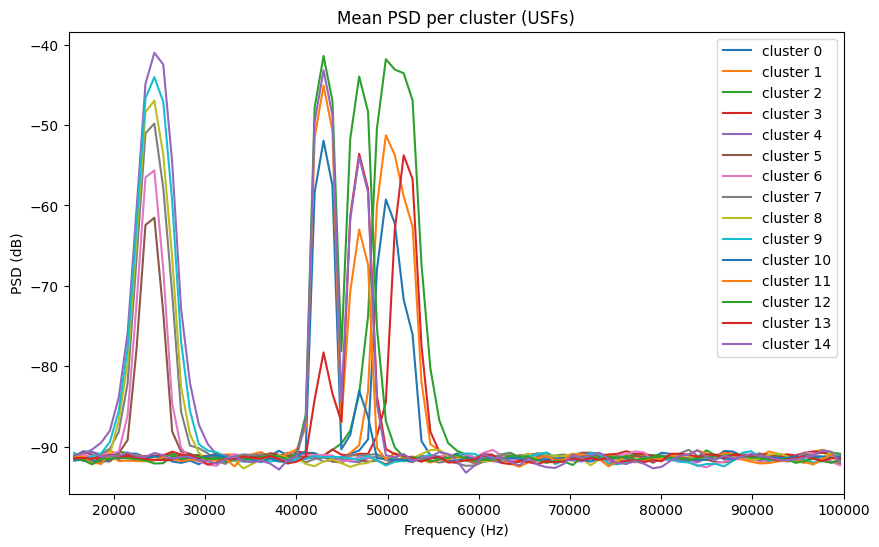

In [1]:
# TrackUSF-like pipeline (Colab-ready)
# Executar no Google Colab (ou qualquer Jupyter). Requer: librosa, soundfile, sklearn, matplotlib, scipy.
# Implementa: pool clips -> fragmentos 6 ms -> 15 kHz HP -> selecionar fragments por potência -> 15-100 kHz PSD -> 16 MFCCs -> t-SNE 3D -> DBSCAN -> overlay em spectrogram

import importlib
import sys
import subprocess

# Lista das bibliotecas que você quer garantir que estejam instaladas
required_libs = [
    "librosa",
    "soundfile",
    "scikit-learn",
    "matplotlib",
    "scipy"
]

# Verifica quais estão ausentes
missing_libs = []
for lib in required_libs:
    try:
        importlib.import_module(lib)
    except ImportError:
        missing_libs.append(lib)

# Instala apenas as que faltam
if missing_libs:
    print(f"Instalando bibliotecas ausentes: {', '.join(missing_libs)}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing_libs, "-q"])
else:
    print("✅ Todas as bibliotecas já estão instaladas.")

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import butter, sosfiltfilt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ---------------------------
# PARAMETERS (ajuste aqui)
SR = 250000               # sample rate (paper used 250 kHz)
FRAG_MS = 6               # fragment length in ms (TrackUSF uses 6 ms)
HP_CUTOFF = 15000         # 15 kHz high-pass cutoff
PSD_MIN_F = 15000         # 15 kHz
PSD_MAX_F = 100000        # 100 kHz
N_MFCC = 16               # 16 MFCCs
N_MELS = 64               # mel bins used for MFCC internals
TSNE_PERPLEXITY = 30      # t-SNE perplexity (paper used large but 30 is typical)
TSNE_N_ITER = 1000
DBSCAN_EPS = 1.0          # eps in t-SNE space — ajuste conforme necessário
DBSCAN_MIN_SAMPLES = 10
THRESH_TYPE = "percentile" # "percentile" or "zscore" or "absolute"
THRESH_VALUE = 85         # if percentile: keep fragments above this percentile of power
# ---------------------------

# helper: high-pass filter (zero-phase)
def hp_filter(sig, sr, cutoff=15000, order=4):
    sos = butter(order, cutoff, btype='highpass', fs=sr, output='sos')
    return sosfiltfilt(sos, sig)

# helper: split into fragments (samples)
def split_fragments(sig, sr, frag_ms=6):
    frag_len = int(sr * frag_ms / 1000)
    n_frags = int(np.floor(len(sig) / frag_len))
    fragments = sig[:n_frags*frag_len].reshape(n_frags, frag_len)
    # compute fragment start times in seconds
    starts = (np.arange(n_frags) * frag_len) / sr
    return fragments, starts

# compute power (RMS) per fragment
def fragment_power(frags):
    return np.sqrt(np.mean(frags**2, axis=1))

# compute MFCC per fragment: average MFCCs over time-frames inside the fragment
def fragment_mfcc(frags, sr, n_mfcc=16, n_mels=64, fmin=15000, fmax=100000):
    mfccs = []
    for frag in frags:
        # librosa expects float32
        y = frag.astype(np.float32)
        # ensure n_fft < len(y) ideally; set n_fft = next power of 2 <= len(y)
        frag_len = len(y)
        n_fft = 1
        while n_fft*2 <= frag_len:
            n_fft *= 2
        n_fft = max(256, n_fft)   # at least 256
        hop_length = max(1, n_fft // 4)
        # compute MFCC with limited fmin/fmax (this works because sr >> fmax)
        S_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc,
                                      n_fft=n_fft, hop_length=hop_length,
                                      n_mels=n_mels, fmin=fmin, fmax=fmax)
        # average over time frames -> single vector per fragment
        vec = np.mean(S_mfcc, axis=1)
        mfccs.append(vec)
    return np.vstack(mfccs)  # shape: (n_fragments, n_mfcc)

# Spectral plot helper
def plot_spectrogram(sig, sr, title="Spectrogram", usf_times=None, usf_clusters=None):
    plt.figure(figsize=(12,4))
    n_fft = 1024
    hop_length = 256
    S = librosa.stft(sig.astype(np.float32), n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz')
    plt.ylim(0, 100000)
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    # overlay USF times as vertical marks
    if usf_times is not None:
        for i,t in enumerate(usf_times):
            c = 'w'
            if usf_clusters is not None:
                # map cluster to color
                cmap = plt.cm.get_cmap('tab10')
                c = cmap(usf_clusters[i] % 10)
            plt.axvline(t, color=c, alpha=0.6, linewidth=0.8)
    plt.show()

# ---------------------------
# Create 3 simulated ultrasonic audio clips (or load files)
# Each clip is 5 seconds long for demo
def generate_synthetic_clip(sr, duration_s=5.0, freqs=[22000, 50000, 35000], amps=[0.5,0.4,0.3], snr_db=20):
    t = np.linspace(0, duration_s, int(sr*duration_s), endpoint=False)
    sig = np.zeros_like(t)
    # create a few bursts at the chosen ultrasonic freqs
    for f,a in zip(freqs, amps):
        # bursts at random times
        for center in np.linspace(0.5, duration_s-0.5, num=3):
            width = 0.02 + 0.05*np.random.rand()
            env = np.exp(-((t-center)**2)/(2*(width**2)))
            sig += a * env * np.sin(2*np.pi*f*t)
    # add some broadband noise
    noise = np.random.normal(0, 1, len(t))
    # scale noise to achieve SNR
    sig_power = np.mean(sig**2)
    noise_power = sig_power / (10**(snr_db/10))
    noise = noise * np.sqrt(noise_power / np.mean(noise**2))
    return sig + noise

# produce 3 clips simulating different animals/calls
clips = []
for freqs in ([50000, 52000], [25000, 24000], [43000, 47000]):
    clips.append(generate_synthetic_clip(SR, duration_s=5.0, freqs=freqs))

# If you have real WAV files, replace clips list with loaded arrays:
# Example:
# import glob
# clips = []
# paths = glob.glob('/path/to/*.wav')[:4]
# for p in paths:
#     y, sr_file = librosa.load(p, sr=SR)   # resample to SR if needed
#     clips.append(y)

# ---------------------------
# RUN PIPELINE: pool clips and analyze together (like TrackUSF)
all_frag_mfcc = []
all_frag_times = []   # (clip_index, fragment_start_time)
all_frag_powers = []
frag_clip_idx = []

for idx, clip in enumerate(clips):
    # 1) high-pass filter (15 kHz) on clip
    clip_hp = hp_filter(clip, SR, cutoff=HP_CUTOFF, order=6)
    # 2) split into 6-ms fragments
    frags, starts = split_fragments(clip_hp, SR, frag_ms=FRAG_MS)
    # 3) compute fragment power
    powers = fragment_power(frags)
    # store powers and times
    all_frag_powers.append(powers)
    # 4) for efficiency, compute MFCCs for all fragments of this clip
    mfccs = fragment_mfcc(frags, sr=SR, n_mfcc=N_MFCC, n_mels=N_MELS,
                          fmin=PSD_MIN_F, fmax=PSD_MAX_F)
    # append
    all_frag_mfcc.append(mfccs)
    # record times
    for s in starts:
        all_frag_times.append((idx, s))
    frag_clip_idx.extend([idx]*len(frags))

all_frag_mfcc = np.vstack(all_frag_mfcc)   # (total_frags, N_MFCC)
all_frag_powers = np.hstack(all_frag_powers)

print(f"Total fragments pooled: {all_frag_mfcc.shape[0]}")

# 5) select USFs by power threshold (user defines)
if THRESH_TYPE == "percentile":
    thresh = np.percentile(all_frag_powers, THRESH_VALUE)
elif THRESH_TYPE == "zscore":
    mean_p = np.mean(all_frag_powers); std_p = np.std(all_frag_powers)
    thresh = mean_p + THRESH_VALUE * std_p
else:
    thresh = THRESH_VALUE

is_usf = all_frag_powers >= thresh
print(f"Selected {np.sum(is_usf)} USFs (threshold = {thresh:.5e})")

# keep only USF MFCCs
usf_mfcc = all_frag_mfcc[is_usf]
usf_meta = np.array(all_frag_times)[is_usf]   # shape (n_usf, 2) with (clip_idx, start_time)
usf_powers = all_frag_powers[is_usf]
usf_clipidx = np.array(frag_clip_idx)[is_usf]

# 6) scale MFCCs and reduce dimensionality with t-SNE to 3D for visualization
scaler = StandardScaler()
usf_mfcc_z = scaler.fit_transform(usf_mfcc)

print("Running t-SNE (this may take ~10-60s depending on data size)...")
tsne = TSNE(n_components=3, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, init='pca', random_state=0)
usf_emb = tsne.fit_transform(usf_mfcc_z)

# 7) cluster t-SNE embedding with DBSCAN
db = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit(usf_emb)
labels = db.labels_  # -1 = noise

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN clusters found: {n_clusters} (including noise label -1)")

# 8) Plot results: t-SNE 3D scatter
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab20', len(unique_labels))
for lab in unique_labels:
    mask = (labels == lab)
    ax.scatter(usf_emb[mask,0], usf_emb[mask,1], usf_emb[mask,2], s=8, alpha=0.7,
               label=f"Cluster {lab}", c=colors(np.where(unique_labels==lab)[0])[None,:])
ax.set_title("t-SNE 3D of USFs (MFCC features)")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.show()

# 9) For each clip: plot spectrogram and overlay USF times colored by cluster
for clip_idx, clip in enumerate(clips):
    # gather USF times and labels for this clip
    sel = (usf_clipidx == clip_idx)
    times = usf_meta[sel][:,1].astype(float)
    labs = labels[sel]
    title = f"Clip {clip_idx} spectrogram with USFs (clusters)"
    plot_spectrogram(clip, SR, title=title, usf_times=times, usf_clusters=labs)

# 10) Optional: per-cluster PSD (mean) estimation (like TrackUSF)
import scipy.signal as sps
def mean_psd_for_indices(indices, sr, frags, fmin=15000, fmax=100000):
    # indices are indices into pooled fragments; we'll recompute PSD for those fragments
    psds = []
    for idx in indices:
        # extract fragment from pooled structure: we reconstruct by using usf_meta and clip fragments
        clip_i, t0 = usf_meta[idx]
        clip_i = int(clip_i)
        t0 = float(t0)
        frag_len = int(SR*FRAG_MS/1000)
        start_sample = int(t0*SR)
        seg = clips[clip_i][start_sample:start_sample+frag_len]
        f, Pxx = sps.welch(seg, fs=SR, nperseg=256, noverlap=128)
        # select range
        mask = (f >= fmin) & (f <= fmax)
        psds.append( (f[mask], Pxx[mask]) )
    # compute mean interpolated PSD on common freq axis if not empty
    if len(psds) == 0:
        return None, None
    # choose base freq vector
    fbase = psds[0][0]
    Pstack = np.vstack([p for (f,p) in psds])
    Pmean = np.mean(Pstack, axis=0)
    return fbase, Pmean

# compute mean PSD per cluster and plot
clusters = [lab for lab in set(labels) if lab!=-1]
plt.figure(figsize=(10,6))
for cl in clusters:
    inds = np.where(labels==cl)[0]
    fbase, Pmean = mean_psd_for_indices(inds, SR, None, fmin=PSD_MIN_F, fmax=PSD_MAX_F)
    if fbase is None:
        continue
    plt.plot(fbase, 10*np.log10(Pmean+1e-12), label=f"cluster {cl}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (dB)")
plt.xlim(PSD_MIN_F, PSD_MAX_F)
plt.legend()
plt.title("Mean PSD per cluster (USFs)")
plt.show()

# End of pipeline


In [ ]:
print(labels)

[-1 -1 -1 -1 -1  3  3 -1 -1 -1 -1  1 -1  1  1  0 -1  0  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1  1  1  1 -1 -1 -1 -1  3  3 -1 -1
 -1 -1 -1  2  2  2  2  2  2  2  2 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  2  2  2  2  2
  2  2 -1 -1 -1 -1  3  3 -1 -1 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  0 -1 -1  1 -1 -1 -1  3  3  3  3 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1  4  4  4 -1  4  4 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  4  4  4  4  4  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4  4  4  4  4  4  4
  4  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5  5  5  5  5
  5 -1  5  5 -1 -1 -1 -1 -1  8  8  8  8  8 -1 -1 -1 -1  6  6  6  6  6  6
  6 -1 -1  6 -1 -1  8  8 -1 -1 -1 -1 -1 -1 -1 -1  5  5  5  5  5  5  5  7
  7  7  7  7 -1 -1 -1 -1 -1 -1  8 -1 -1 -1  6  6  6